In [18]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

In [16]:
from pathlib import Path

def read_fusions(file_path):
    """Reads fusions from STAR-Fusion final candidate file."""
    
    col_names = ['fusion_name', 'support_junction', 
                 'support_spanning', 'splice_type',
                 'left_gene', 'left_breakpoint', 'right_gene', 
                 'right_breakpoint', 'junction_reads',
                 'spanning_reads', 'extra']
    
    return (pd.read_csv(str(file_path), sep='\t', header=None,
                        skiprows=1, index_col=None, names=col_names)
              .drop('extra', axis=1))

# Read fusions for samples.
base_dir = Path('../data/interim/sb/star-fusion/fusions')
fusion_paths = list(base_dir.glob('**/star-fusion.fusion_candidates.final'))

fusions = {fusion_path.parent.name: read_fusions(fusion_path)
           for fusion_path in fusion_paths}

# Merge into single frame.
merged = pd.concat((df.assign(sample=sample) 
                    for sample, df in fusions.items()),
                   axis=0, ignore_index=True)
merged_ref = merged.query('splice_type == "ONLY_REF_SPLICE"')

merged.head()

,fusion_name,support_junction,support_spanning,splice_type,left_gene,left_breakpoint,right_gene,right_breakpoint,junction_reads,spanning_reads,sample
0,Mpp2--Erich2,5.0,0.0,INCL_NON_REF_SPLICE,Mpp2^ENSMUSG00000017314,11:102057731:-,Erich2^ENSMUSG00000075302,2:70509335:+,"HWI-ST383:195:D1G4DACXX:5:1209:6622:22285,HWI-...",.,2049_10_11KOU049-R3
1,Cox6b1--En2,4.0,0.0,ONLY_REF_SPLICE,Cox6b1^ENSMUSG00000036751,7:30624500:-,En2^ENSMUSG00000039095,5:28170119:+,"HWI-ST383:195:D1G4DACXX:5:2104:11668:75600,HWI...",.,2049_10_11KOU049-R3
2,Plekhh2--Rps12-ps17,4.0,0.0,INCL_NON_REF_SPLICE,Plekhh2^ENSMUSG00000040852,17:84566150:+,Rps12-ps17^ENSMUSG00000095137,X:125548022:-,"HWI-ST383:195:D1G4DACXX:5:1106:2334:92199,HWI-...",.,2049_10_11KOU049-R3
3,Igkv15-103--Igkj2,4.0,0.0,INCL_NON_REF_SPLICE,Igkv15-103^ENSMUSG00000076523,6:68437922:+,Igkj2^ENSMUSG00000076605,6:70722917:+,"HWI-ST383:195:D1G4DACXX:5:2316:17423:72219,HWI...",.,2049_10_11KOU049-R3
4,Ryr3--Sox10,4.0,0.0,INCL_NON_REF_SPLICE,Ryr3^ENSMUSG00000057378,2:112847531:-,Sox10^ENSMUSG00000033006,15:79155313:-,"HWI-ST383:195:D1G4DACXX:5:1214:20135:18862,HWI...",.,2049_10_11KOU049-R3


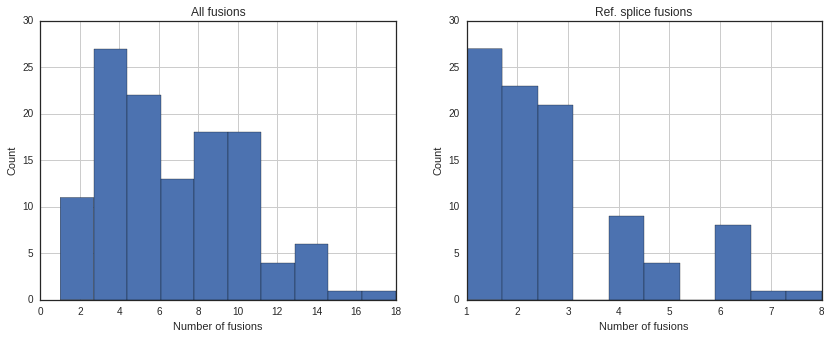

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
merged.groupby('sample').size().hist(ax=axes[0])
axes[0].set_title('All fusions')
axes[0].set_xlabel('Number of fusions')
axes[0].set_ylabel('Count')

merged_ref.groupby('sample').size().hist(ax=axes[1])
axes[1].set_title('Ref. splice fusions');
axes[1].set_xlabel('Number of fusions')
axes[1].set_ylabel('Count');

In [55]:
(merged_ref.groupby('fusion_name')['sample'].nunique()
           .sort_values(ascending=False).head(n=20))

fusion_name
Trps1--En2              21
Fgfr2--En2              15
Ppp1r12a--En2           15
Foxf2--Trp53bp2         14
Myh9--En2               11
Foxf2--Fgfr2            10
Foxf2--Eras              6
Foxf2--Rasgrf1           5
Foxf2--Gab1              5
Ppp1r12b--En2            4
Runx1--En2               4
Tgfbr2--En2              4
Cblb--En2                4
4930448N21Rik--Stox2     3
Foxf2--Gmds              3
Suco--En2                2
Foxf2--Plce1             2
Foxf2--Erg               2
Trp53bp2--En2            2
Foxf2--Ddx10             1
Name: sample, dtype: int64

In [56]:
def filter_transposon(fusions):
    mask = fusions['fusion_name'].str.contains('En2|Foxf2')
    return fusions.loc[~mask]

(merged_ref.pipe(filter_transposon)
           .groupby('fusion_name')['sample'].nunique())

fusion_name
4930448N21Rik--Stox2    3
Atxn7l1os1--Fam173b     1
Cnksr3--Cand1           1
Cnst--Smyd3             1
Cpq--Sdc2               1
Fgfr2--Kif16b           1
Fgfr2--Myh9             1
Fgfr2--Tbc1d1           1
Frs2--Arhgef25          1
Frs2--Dtx3              1
Frs2--Rap1b             1
Gm13830--Gnas           1
Gsr--Znrf1              1
Igkv1-110--Igkj1        1
Igkv1-110--Igkj4        1
Igkv1-110--Igkj5        1
Igkv1-135--Igkc         1
Il1rap--Eci2            1
Nfyc--Raly              1
Trp53bp2--Dst           1
Zfp1--Znrf1             1
Name: sample, dtype: int64

In [62]:
(merged_ref.pipe(filter_transposon)
           .sort_values('fusion_name')
           .to_excel('../reports/star_fusion.sb.xlsx', index=False))